#### Set up environments

In [36]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew 

from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier  
from sklearn import svm 
from sklearn import metrics
from sklearn.metrics import mean_squared_error 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

#### Input data

In [37]:
train_data = pd.read_csv('data\houseprice_train.csv')

In [38]:
test_data = pd.read_csv('data\houseprice_test.csv')

In [39]:
train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Remove Outliers

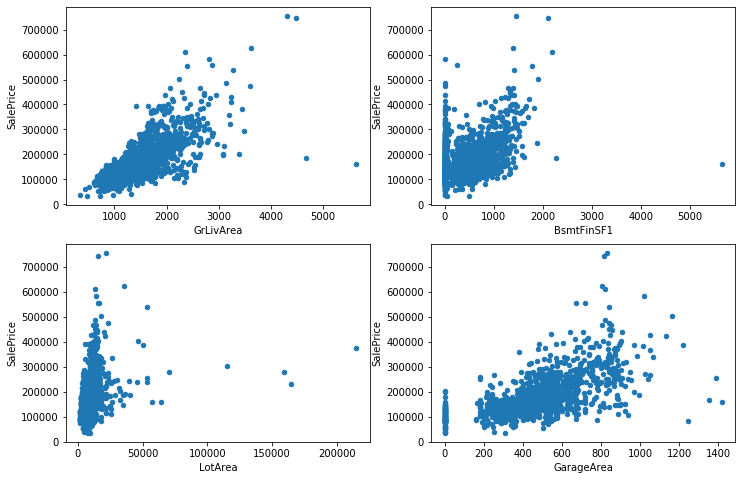

In [40]:
fig, axarr = plt.subplots(2, 2, figsize = (12, 8))
train_data.plot.scatter(
    x="GrLivArea", 
    y="SalePrice", 
    ax=axarr[0][0]
)
train_data.plot.scatter(
    x="BsmtFinSF1", 
    y="SalePrice", 
    ax=axarr[0][1]
)
train_data.plot.scatter(
    x="LotArea", 
    y="SalePrice", 
    ax=axarr[1][0]
)
train_data.plot.scatter(
    x="GarageArea", 
    y="SalePrice", 
    ax=axarr[1][1]
)

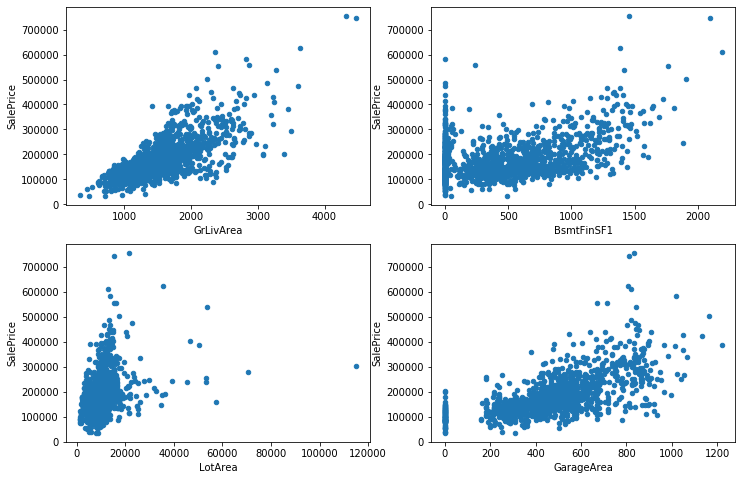

In [41]:
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<300000)].index)
train_data = train_data.drop(train_data[(train_data['LotArea']>150000)].index)
train_data = train_data.drop(train_data[(train_data['GarageArea']>1200) & (train_data['SalePrice']<300000)].index)
fig, axarr = plt.subplots(2, 2, figsize = (12, 8))
train_data.plot.scatter(
    x="GrLivArea", 
    y="SalePrice", 
    ax=axarr[0][0]
)
train_data.plot.scatter(
    x="BsmtFinSF1", 
    y="SalePrice", 
    ax=axarr[0][1]
)
train_data.plot.scatter(
    x="LotArea", 
    y="SalePrice", 
    ax=axarr[1][0]
)
train_data.plot.scatter(
    x="GarageArea", 
    y="SalePrice", 
    ax=axarr[1][1]
)

##### Apply Log transfomation to SalePrice

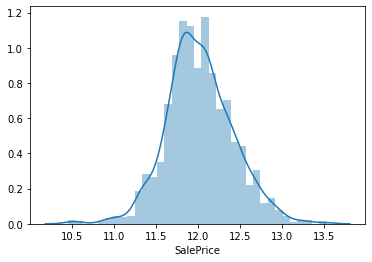

In [42]:
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])
sns.distplot(train_data['SalePrice']);

##### Concat train data and test data

In [43]:
Id = test_data['Id']
train_y = train_data.SalePrice.values
all_data = pd.concat((train_data, test_data), sort=False).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))
all_data.head(5)

all_data size is : (2911, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


#### Dealing with missing data

In [44]:
all_data = all_data.drop('Id', axis=1)

missing_data = all_data.isnull().sum()
missing_data = missing_data.drop(missing_data[missing_data == 0].index)
missing_ratio = missing_data / len(all_data) * 100

all_data = all_data.drop(missing_ratio[missing_ratio.values > 20].index, axis=1)

all_data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal


In [16]:
missing_data = all_data.isnull().sum()
missing_data = missing_data.drop(missing_data[missing_data == 0].index)
missing_ratio = missing_data / len(all_data) * 100
print(missing_ratio)
all_data[missing_ratio.index].head(5)

MSZoning         0.137410
LotFrontage     16.592236
Utilities        0.068705
Exterior1st      0.034352
Exterior2nd      0.034352
MasVnrType       0.824459
MasVnrArea       0.790106
BsmtQual         2.782549
BsmtCond         2.816901
BsmtExposure     2.816901
BsmtFinType1     2.713844
BsmtFinSF1       0.034352
BsmtFinType2     2.748196
BsmtFinSF2       0.034352
BsmtUnfSF        0.034352
TotalBsmtSF      0.034352
Electrical       0.034352
BsmtFullBath     0.068705
BsmtHalfBath     0.068705
KitchenQual      0.034352
Functional       0.068705
GarageType       5.393336
GarageYrBlt      5.462041
GarageFinish     5.462041
GarageCars       0.034352
GarageArea       0.034352
GarageQual       5.462041
GarageCond       5.462041
SaleType         0.034352
dtype: float64


,MSZoning,LotFrontage,Utilities,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,...,KitchenQual,Functional,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,SaleType
0,RL,65.0,AllPub,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,No,...,Gd,Typ,Attchd,2003.0,RFn,2.0,548.0,TA,TA,WD
1,RL,80.0,AllPub,MetalSd,MetalSd,None,0.0,Gd,TA,Gd,...,TA,Typ,Attchd,1976.0,RFn,2.0,460.0,TA,TA,WD
2,RL,68.0,AllPub,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,Mn,...,Gd,Typ,Attchd,2001.0,RFn,2.0,608.0,TA,TA,WD
3,RL,60.0,AllPub,Wd Sdng,Wd Shng,None,0.0,TA,Gd,No,...,Gd,Typ,Detchd,1998.0,Unf,3.0,642.0,TA,TA,WD
4,RL,84.0,AllPub,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,Av,...,Gd,Typ,Attchd,2000.0,RFn,3.0,836.0,TA,TA,WD


In [17]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
all_data['Utilities'] = all_data['Utilities'].fillna(all_data['Utilities'].mode()[0])
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Utilities'] = all_data['Utilities'].fillna(all_data['Utilities'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['MasVnrType'] = all_data['MasVnrType'].fillna(all_data['MasVnrType'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Functional'] = all_data['Functional'].fillna(all_data['Functional'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['BsmtQual'] = all_data['BsmtQual'].fillna('None')
all_data['BsmtCond'] = all_data['BsmtCond'].fillna('None')
all_data['BsmtExposure'] = all_data['BsmtExposure'].fillna('None')
all_data['BsmtFinType1'] = all_data['BsmtFinType1'].fillna('None')
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].fillna('None')
all_data['GarageType'] = all_data['GarageType'].fillna('None')
all_data['GarageFinish'] = all_data['GarageFinish'].fillna('None')
all_data['GarageQual'] = all_data['GarageQual'].fillna('None')
all_data['GarageCond'] = all_data['GarageCond'].fillna('None')
all_data['BsmtFinSF1'] = all_data['BsmtFinSF1'].fillna(0)
all_data['BsmtFinSF2'] = all_data['BsmtFinSF2'].fillna(0)
all_data['BsmtUnfSF'] = all_data['BsmtUnfSF'].fillna(0)
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].fillna(0)
all_data['BsmtFullBath'] = all_data['BsmtFullBath'].fillna(0)
all_data['BsmtHalfBath'] = all_data['BsmtHalfBath'].fillna(0)
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)
all_data['GarageCars'] = all_data['GarageCars'].fillna(0)
all_data['GarageArea'] = all_data['GarageArea'].fillna(0)

In [18]:
all_data = pd.get_dummies(all_data)
all_data.head(5)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,0,1,0,0,0,0,1,0


##### Split to train and test data

In [19]:
ntrain = train_data.shape[0]
ntest = test_data.shape[0]
train = all_data[:ntrain]
test = all_data[ntrain:]
train_x = train
print(train_x.shape[0], train_y.shape[0])

1452 1452


##### Cross validation

In [20]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, train_y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

#### Select an algorithm

We wanted to use lightbgm initially, however, after looking through a great number of related articles, we still failed to solve the problem "No module named 'lightgbm'", and we ran out of time. As a consequence, we determined to use GradientBoostingRegressor to predict the sales prices.

In [30]:
import lightgbm as lgb

ModuleNotFoundError: No module named 'lightgbm'

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor ( loss='huber', n_estimators=150) 
score = rmsle_cv(model)
print("GBR score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

GBR score: 0.1191 (0.0061)



##### Mean square error validation 

In [34]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

##### Train the selected model

In [33]:
model.fit(train_x, train_y)
train_prediction = model.predict(train)
prediction = np.expm1(model.predict(test.values))
print(rmsle(train_y, train_prediction))
# print(prediction)

0.08073781404963243


# Conclusion

1. At my first attempt, I dropped all the columns that contain missing value. That's one way. The next attemt I tried to simply fill them with either some common value, or 0, or None.

2. Due to the limitation of time, we merely adapted GradientBoostingRegressor in this case and only evaluated this model, which means that we did not have camparison data and it is hard to tell whether the result is better than other algorithms.

# Addition Notes

After trying all variety of methods, we failed to import lightgbm into Anaconda environment. It is a very useful algorithm, which is likely to be a great model to predict the sales prices.